In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import k_means

In [2]:
x1 = np.random.normal(loc=4.0, scale=0.5, size=100)
y1 = np.random.normal(loc=3.0, scale=0.5, size=100)
x2 = np.random.normal(loc=1.5, scale=0.7, size=100)
y2 = np.random.normal(loc=1.5, scale=0.7, size=100)
x3 = np.random.normal(loc=5.0, scale=0.7, size=100)
y3 = np.random.normal(loc=1.5, scale=0.7, size=100)

x = np.hstack((x1, x2, x3))
y = np.hstack((y1, y2, y3))
tss = np.sum((x-x.mean())**2 + (y-y.mean())**2)

X = np.array(zip(x,y))

In [9]:
k_vals = range(1,11)
wss_vals = []
ch_vals = []

for k in k_vals:
    centers, labels, wss = k_means(X, n_clusters=k)
    ch = ((tss-wss)/(k-1))/(wss/(X.size-k))
    wss_vals.append(wss)
    ch_vals.append(ch)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


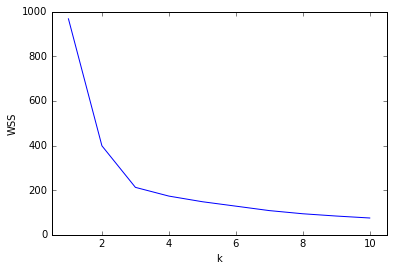

In [7]:
plt.plot(k_vals, wss_vals)
plt.xlim(0.5,10.5)
plt.xlabel('k')
plt.ylabel('WSS')

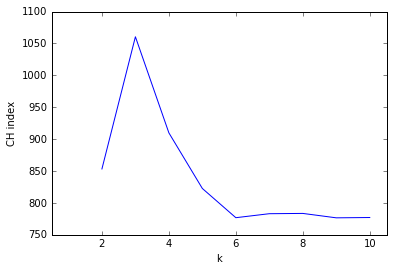

In [8]:
plt.plot(k_vals, ch_vals)
plt.xlim(0.5,10.5)
plt.xlabel('k')
plt.ylabel('CH index')